In [1]:
!conda activate asl

'conda' is not recognized as an internal or external command,
operable program or batch file.


# Exam DS807

## Preparation of data

### Labeling Data and converting images to array values

In [70]:
#import packages for labelling and converting imagery data
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import VGG16
from numpy import asarray
from sklearn import svm
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from keras import layers
from keras import models
from keras.applications.vgg16 import VGG16
from keras import optimizers
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
##############
# Func for creating 1D image arrays

def load_image_function(path):
    images = [] # empty list placeholder
    labels = [] # empty list placeholder
    container = [] # container to validate correct labels
    for filename in os.listdir(path):
        container.append(filename) # add filename to container     
        CCDY_img = load_img(path + f'/{filename}', target_size = (56, 106),
        color_mode="grayscale")                  
        CCDY_img = img_to_array(CCDY_img)
        images.append(CCDY_img) # append the photo to the images. The images list contains a list of arrays       
    return asarray(images), container; # not interested in list of arrays, but array containing lists. Asarray does this. Returns three arrays


In [4]:
################
# Func for creating df with classes and 3d img arrays

def load_img_data ():
    # Start: creatign classes ons string_digits
    # load string digits

    #os.chdir(path_string_digits)

    string_digits = pd.read_csv('DIDA_12000_String_Digit_Labels.csv', 
                 header = None, 
                 names=["index", "string"])
    # create empty class columns
    string_digits['CC'] = 0
    string_digits['D'] = 0
    string_digits['Y'] = 0
    string_digits = string_digits.astype(str)
    # Iterate string digits and append classes
    for i, row in string_digits.iterrows():
        if len(row['string']) != 4:
            row['CC'] = '1'
            row['D'] = '10'
            row['Y'] = '10'
        else:
            row['D'] = row['string'][2]
            row['Y'] = row['string'][3]
            if row['string'][0:2] == '18':
                row['CC']='0'
            else:
                row['CC']='1'
    # End of class labeling on string_digits.
    #
    # Start: create img_df containing scaled images as 1D tensors
    # Convert imagery to 1D arrays with tagged file names

    #os.chdir(path_images)
    image_array, filename = load_image_function('DIDA_12000_String_Digit_Images/DIDA_1')

    # and convert to a img_df
    img_df = pd.DataFrame({'filename': filename, 'img_value': list(image_array)}, 
                          columns=['filename', 'img_value'])
    # Create proper index value in img_df to allow merge on string_digits
    img_df['index'] = img_df['filename']
    for i, row in img_df.iterrows():
        row['index'] = str(img_df['index'][i]).split('.')[0]
    img_df
    # End of creating img_df
    #
    # Start: merge img_df with string_digits
    # match index type on dataframes to merge
    string_digits['index'] = string_digits['index'].astype(int)
    img_df['index'] = img_df['index'].astype(int)
    # Merge dataframes
    df_img_classes = string_digits.merge(img_df)
    # Rearrange order of dataframe
    df_img_classes = df_img_classes.reindex(columns= ['index', 'string', 'CC', 'D', 'Y', 'img_value', 'filename'])
    # End og merging data frames
    return df_img_classes


In [5]:
#load data and shuffle them around
df = load_img_data()
df = df.sample(frac=1).reset_index(drop=True)
df

,index,string,CC,D,Y,img_value,filename
0,9731,1812,0,1,2,"[[[38.0], [33.0], [64.0], [121.0], [140.0], [1...",9731.jpg
1,10592,1828,0,2,8,"[[[86.0], [83.0], [79.0], [75.0], [78.0], [76....",10592.jpg
2,680,1825,0,2,5,"[[[126.0], [124.0], [123.0], [124.0], [125.0],...",680.jpg
3,6124,1803,0,0,3,"[[[184.0], [185.0], [185.0], [184.0], [183.0],...",6124.jpg
4,10120,1801,0,0,1,"[[[158.0], [158.0], [157.0], [157.0], [153.0],...",10120.jpg
...,...,...,...,...,...,...,...
11995,2904,9325,1,2,5,"[[[189.0], [191.0], [193.0], [194.0], [194.0],...",2904.jpg
11996,5758,1821,0,2,1,"[[[13.0], [12.0], [11.0], [12.0], [12.0], [12....",5758.jpg
11997,7718,1815,0,1,5,"[[[25.0], [26.0], [25.0], [21.0], [19.0], [21....",7718.jpg
11998,1808,1821,0,2,1,"[[[147.0], [148.0], [148.0], [146.0], [145.0],...",1808.jpg


### Defining fixed train, test and valdiation sets.

In [6]:
df = df.drop(columns=['index','string','filename'])

### Split train, val, test

#### Subsetting df

In [7]:
x_train = df.loc[0:7679]
x_val = df.loc[7680:9599]
x_test = df.loc[9600:11999]

#### Creating labels

In [8]:
#### training labels ###
Y_train = x_train['Y']
Y_train = Y_train.astype(np.uint8)
D_train = x_train['D']
D_train = D_train.astype(np.uint8)
CC_train = x_train['CC']
CC_train = CC_train.astype(np.uint8)

#### validation labels ###
Y_val = x_val['Y']
Y_val = Y_val.astype(np.uint8)
D_val = x_val['D']
D_val = D_val.astype(np.uint8)
CC_val = x_val['CC']
CC_val = CC_val.astype(np.uint8)

#### test labels ###
Y_test = x_test['Y']
Y_test = Y_test.astype(np.uint8)
D_test = x_test['D']
D_test = D_test.astype(np.uint8)
CC_test = x_test['CC']
CC_test = CC_test.astype(np.uint8)


#### Creating image values

In [9]:
# train
values = np.zeros(shape=(len(x_train),56,106,1))
i = 0
j = 0
while i < len(x_train):
    values[i] = x_train['img_value'][j]
    i += 1
    j+=1
x_train = values/255

# val
values = np.zeros(shape=(len(x_val),56,106,1))
i = 0
j = 7680
while i < len(x_val):
    values[i] = x_val['img_value'][j]
    i += 1
    j+=1
x_val = values/255

# test
values = np.zeros(shape=(len(x_test),56,106,1))
i = 0
j = 9600
while i < len(x_test):
    values[i] = x_test['img_value'][j]
    i += 1
    j+=1
x_test = values/255


## Question 1

### 1.2 Non-deeplearning CC-D-Y models

In [10]:
x_train_flat = x_train.reshape((len(x_train), -1))
x_val_flat = x_val.reshape((len(x_val), -1))
x_test_flat = x_test.reshape((len(x_test), -1))

In [24]:
def score_calc(model,y_test,x_test):
    score = 0.0
    preds = model.predict(x_test)
    i = 0
    for row in y_test:
        if str(row) == str(preds[i][0]):
            score = score + (1/3)
        i= i + 1
    return score

#### SVM, modelCC

In [11]:
model = svm.SVC()
model.fit(x_train_flat, CC_train)
val_hat = model.predict(x_val_flat)
accuracy = accuracy_score(val_hat, CC_val)*100
accuracy

97.55208333333333

#### Catboost, modelD

In [16]:
results_catboost_D = []
n_iterations = [100,200,500]
lr = [0.01,0.1]
n_depth = [4,6]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_D = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_D.fit(x_train_flat, D_train, verbose=50)
            acc = model_D.score(x_val_flat,D_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results_catboost_D.append([acc,ls,iters, depths])
            print([acc,ls,iters, depths])
results_df_catboost_D = pd.DataFrame(results_catboost_D)
results_df_catboost_D.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df_catboost_D = results_df_catboost_D.sort_values('accuracy', ascending=False)
results_df_catboost_D


0:	learn: 2.2887629	total: 136ms	remaining: 13.5s
50:	learn: 1.8662520	total: 4.91s	remaining: 4.72s
99:	learn: 1.6777988	total: 9.37s	remaining: 0us
[0.396875, 0.01, 100, 4]
0:	learn: 2.2886103	total: 330ms	remaining: 32.7s
50:	learn: 1.8515984	total: 16.2s	remaining: 15.6s
99:	learn: 1.6450200	total: 31.7s	remaining: 0us
[0.44114583333333335, 0.01, 100, 6]
0:	learn: 2.1705851	total: 115ms	remaining: 11.3s
50:	learn: 1.3272531	total: 4.69s	remaining: 4.51s
99:	learn: 1.1892576	total: 9.17s	remaining: 0us
[0.5171875, 0.1, 100, 4]
0:	learn: 2.1687604	total: 328ms	remaining: 32.5s
50:	learn: 1.2001364	total: 16.6s	remaining: 16s
99:	learn: 1.0085116	total: 32.4s	remaining: 0us
[0.5536458333333333, 0.1, 100, 6]
0:	learn: 2.2887634	total: 116ms	remaining: 23s
50:	learn: 1.8662523	total: 4.79s	remaining: 14s
100:	learn: 1.6750856	total: 9.27s	remaining: 9.08s
150:	learn: 1.5682842	total: 13.3s	remaining: 4.33s
199:	learn: 1.5017392	total: 17.6s	remaining: 0us
[0.4395833333333333, 0.01, 200,

,accuracy,learning_rate,n_estimators,depth
11,0.627604,0.10,500,6
10,0.593750,0.10,500,4
7,0.585417,0.10,200,6
3,0.553646,0.10,100,6
9,0.553646,0.01,500,6
6,0.549479,0.10,200,4
2,0.517188,0.10,100,4
8,0.505729,0.01,500,4
5,0.504167,0.01,200,6
1,0.441146,0.01,100,6


In [17]:
results_df_catboost_D.to_csv('Catboost_results_DECADE')

In [18]:
test_acc = model_D.score(x_test_flat,D_test)
test_acc

0.6420833333333333

In [25]:
test_Score = score_calc(model_D,D_test,x_test_flat)
test_Score

513.6666666666551

#### Catboost, modelY

In [19]:
results_cat_Y = []
n_iterations = [500]#,200,100]
lr = [0.1]#,0.01]
n_depth = [6]#,4]
loss_f = 'MultiClass'

for iters in n_iterations:
    for ls in lr:
        for depths in n_depth:
            model_Y = CatBoostClassifier(iterations=iters,
                                        learning_rate=ls,
                                        depth=depths,
                                        loss_function=loss_f,
                                        task_type="GPU",
                                        devices='0:1')

            model_Y.fit(x_train_flat, Y_train, verbose=50)
            acc = model_Y.score(x_val_flat,Y_val)
            # the results from the different hyperparameters are then stored so we can get the best one
            results_cat_Y.append([acc,ls,iters, depths])
results_df_cat_Y = pd.DataFrame(results_cat_Y)
results_df_cat_Y.columns=['accuracy',"learning_rate","n_estimators", "depth"]
#prints the results from best to worst in regards to accuracy, listting the hyperparameters for the result
results_df_cat_Y = results_df_cat_Y.sort_values('accuracy', ascending=False)
results_df_cat_Y

0:	learn: 2.3600619	total: 396ms	remaining: 3m 17s
50:	learn: 1.7120842	total: 18.4s	remaining: 2m 42s
100:	learn: 1.4128335	total: 36.3s	remaining: 2m 23s
150:	learn: 1.2094868	total: 53s	remaining: 2m 2s
200:	learn: 1.0706529	total: 1m 9s	remaining: 1m 43s
250:	learn: 0.9751101	total: 1m 24s	remaining: 1m 24s
300:	learn: 0.8843965	total: 1m 40s	remaining: 1m 6s
350:	learn: 0.8116300	total: 1m 55s	remaining: 49.2s
400:	learn: 0.7521682	total: 2m 10s	remaining: 32.3s
450:	learn: 0.7016064	total: 2m 25s	remaining: 15.9s
499:	learn: 0.6563481	total: 2m 40s	remaining: 0us


,accuracy,learning_rate,n_estimators,depth
0,0.547396,0.1,500,6


In [19]:
results_df_cat_Y.to_csv('Catboost_results_YEAR')

In [20]:
test_acc = model_Y.score(x_test_flat,Y_test)
test_acc

0.5541666666666667

In [26]:
test_Score = score_calc(model_Y,Y_test,x_test_flat)
test_Score

443.3333333333256

## Question 2

### 2.2.A Construct a CNN

### 2.2.B Regularization

### 2.2.C Augmentation

### 2.2.D Transfer learning

#### CC model

In [49]:
x_train_transfer = tf.image.grayscale_to_rgb(tf.constant(x_train))
x_test_transfer = tf.image.grayscale_to_rgb(tf.constant(x_test))
x_val_transfer = tf.image.grayscale_to_rgb(tf.constant(x_val))

In [64]:

transfer_model = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model.layers:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = layers.Dense(1, activation='sigmoid')(class1)
# define new model
transfer_model = models.Model(inputs=transfer_model.inputs, outputs=output)

transfer_model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "model_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0  

In [72]:
transfer_history = transfer_model.fit(x_train_transfer,CC_train, steps_per_epoch=len(x_train_transfer), epochs=10,validation_data=(x_val_transfer,CC_val), validation_steps=len(x_val_transfer))

Epoch 1/10
7680/7680 [==============================] - 68s 9ms/step - loss: 0.0322 - accuracy: 0.9909 - val_loss: 0.0556 - val_accuracy: 0.9896
Epoch 2/10
7680/7680 [==============================] - 72s 9ms/step - loss: 0.0253 - accuracy: 0.9923 - val_loss: 0.0615 - val_accuracy: 0.9896
Epoch 3/10
7680/7680 [==============================] - 68s 9ms/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.0531 - val_accuracy: 0.9880
Epoch 4/10
7680/7680 [==============================] - 69s 9ms/step - loss: 0.0199 - accuracy: 0.9937 - val_loss: 0.0663 - val_accuracy: 0.9891
Epoch 5/10
7680/7680 [==============================] - 68s 9ms/step - loss: 0.0174 - accuracy: 0.9948 - val_loss: 0.0688 - val_accuracy: 0.9901
Epoch 6/10
7680/7680 [==============================] - 71s 9ms/step - loss: 0.0154 - accuracy: 0.9948 - val_loss: 0.0638 - val_accuracy: 0.9875
Epoch 7/10
7680/7680 [==============================] - 67s 9ms/step - loss: 0.0146 - accuracy: 0.9954 - val_loss: 0.0716 - val_ac

In [81]:
transfer_model.evaluate(x_test_transfer,D_test)

75/75 [==============================] - 2s 23ms/step - loss: 0.8449 - accuracy: 0.6817


[0.8449097871780396, 0.6816666722297668]

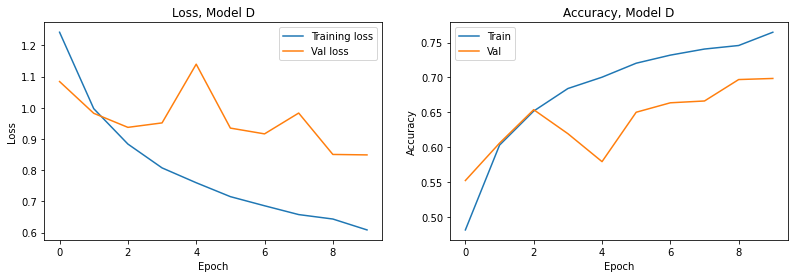

In [80]:
fig = plt.figure(figsize=plt.figaspect(0.3))

ax = fig.add_subplot(1, 2, 1)
ax.plot(transfer_history.history['loss'], label='Training loss')
ax.plot(transfer_history.history['val_loss'], label = 'Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss, Model D')

ax = fig.add_subplot(1, 2, 2)
ax.plot(transfer_history.history['accuracy'], label='Train')
ax.plot(transfer_history.history['val_accuracy'], label = 'Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy, Model D')

plt.show()

#### D Model

In [78]:
transfer_model = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model.layers[0:100]:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = layers.Dense(11, activation='softmax')(class1)
# define new model
transfer_model = models.Model(inputs=transfer_model.inputs, outputs=output)

transfer_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 56, 106, 3)]      0         
                                                                 
 block1_conv1 (Conv2D)       (None, 56, 106, 64)       1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 56, 106, 64)       36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 28, 53, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 28, 53, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 28, 53, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 14, 26, 128)       0  

In [79]:
transfer_history = transfer_model.fit(x_train_transfer,D_train, steps_per_epoch=len(x_train_transfer), epochs=10,validation_data=(x_val_transfer,D_val), validation_steps=len(x_val_transfer))

Epoch 1/10
7680/7680 [==============================] - 68s 9ms/step - loss: 1.2422 - accuracy: 0.4812 - val_loss: 1.0841 - val_accuracy: 0.5521
Epoch 2/10
7680/7680 [==============================] - 65s 8ms/step - loss: 0.9972 - accuracy: 0.6029 - val_loss: 0.9824 - val_accuracy: 0.6057
Epoch 3/10
7680/7680 [==============================] - 65s 8ms/step - loss: 0.8838 - accuracy: 0.6517 - val_loss: 0.9373 - val_accuracy: 0.6536
Epoch 4/10
7680/7680 [==============================] - 65s 9ms/step - loss: 0.8074 - accuracy: 0.6840 - val_loss: 0.9516 - val_accuracy: 0.6193
Epoch 5/10
7680/7680 [==============================] - 93s 12ms/step - loss: 0.7598 - accuracy: 0.7003 - val_loss: 1.1398 - val_accuracy: 0.5792
Epoch 6/10
7680/7680 [==============================] - 63s 8ms/step - loss: 0.7152 - accuracy: 0.7203 - val_loss: 0.9349 - val_accuracy: 0.6500
Epoch 7/10
7680/7680 [==============================] - 63s 8ms/step - loss: 0.6860 - accuracy: 0.7319 - val_loss: 0.9164 - val_a

#### Y Model


In [ ]:
transfer_model = VGG16(include_top=False, input_shape=(56, 106, 3))
# mark loaded layers as not trainable
for layer in transfer_model.layers:
	layer.trainable = False
# add new classifier layers
flat1 = layers.Flatten()(transfer_model.layers[-1].output)
class1 = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1)
output = layers.Dense(11, activation='softmax')(class1)
# define new model
transfer_model = models.Model(inputs=transfer_model.inputs, outputs=output)

transfer_model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

In [ ]:
transfer_history = transfer_model.fit(x_train_transfer,D_train, steps_per_epoch=len(x_train_transfer), epochs=10,validation_data=(x_val_transfer,D_val), validation_steps=len(x_val_transfer))

## 2.3 Prefered CNN model

## Question 3

### 3.1 Visualization of activation maps

### 3.2 Investigating model performance